In [1]:
## Install yamlu package for parsing ease

%pip install yamlu

Note: you may need to restart the kernel to use updated packages.


In [2]:
## Import Packages

import shutil

from pathlib import Path
from yamlu.coco_read import CocoReader

In [3]:
## Setup and settings

PREPROC_DIR = 'handwritten-diagram-datasets/datasets'
POSTPROC_DIR = 'data'
DATASETS = ['fa', 'fca', 'fcb', 'fcb_scan', 'hdBPMN-icdar2021']
SPLITS = ['test', 'train', 'val']

datasets_root = Path(PREPROC_DIR)

### Steps

0. Download the dataset
1. Create directories fa, fca, fcb, fcb_scan, hdBPMN-icdar2021, didi (later on)
2. Look at an exhaustive list of classes.
3. Hardcode in the code itself.
4. Parse bb info from the annotations in the json files
5. Move images from the github folder to these directories/images.
6. Cleanup

Keep the move to the end because we do not wish to disturb the previous steps

In [36]:
## Step 0: Download the dataset

!rm -fr handwritten-diagram-datasets && git clone https://github.com/bernhardschaefer/handwritten-diagram-datasets.git --depth=1

Cloning into 'handwritten-diagram-datasets'...
remote: Enumerating objects: 2602, done.
remote: Counting objects: 100% (2602/2602), done.
remote: Compressing objects: 100% (2597/2597), done.
remote: Total 2602 (delta 11), reused 2593 (delta 5), pack-reused 0
Receiving objects: 100% (2602/2602), 651.92 MiB | 2.86 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (2582/2582), done.


### Directory Structure

```
data
├── fa
│   ├── classes.txt
│   ├── test
│   │   ├── images
│   │   └── labels
│   ├── train
│   │   ├── images
│   │   └── labels
│   └── val
│       ├── images
│       └── labels
├── fca
│   ├── classes.txt
│   ├── test
│   │   ├── images
│   │   └── labels
│   └── train
│       ├── images
│       └── labels
...
```

In [4]:
# Unfortunate but fca does not have a val dataset
def splits(dataset):
    return ['test', 'train', 'val'] if  dataset != 'fca' else ['test', 'train']

In [5]:
## Step 1: Create directories

!rm -fr data

# data -> {dataset} -> {classes.txt, test, train, val} -> {images, labels} -> {...}
for dataset in DATASETS:
    for split in splits(dataset):
        Path(POSTPROC_DIR, dataset, split, 'labels').mkdir(parents=True, exist_ok=True)

In [ ]:
## Step 2: Collect shapes/categories/classes from all json files

shapes = dict()

for dataset in DATASETS:
    categories = set()
    reader = CocoReader(datasets_root / dataset)
    for split in splits(dataset):
        ann_imgs = reader.parse_split(split)
        for ai in ann_imgs:
            categories.update(ai.categories)
        
    shapes[dataset] = list(categories)
    
shapes

In [6]:
## Step 3: Output hardcoded classes into a text file

classes = {
    'fa': ['text', 'final state', 'arrow', 'state'],
    'fca': ['terminator', 'arrow', 'data', 'process', 'text', 'decision', 'connection'],
    'fcb': ['terminator', 'arrow', 'data', 'process', 'text', 'decision', 'connection'],
    'fcb_scan': ['terminator', 'arrow', 'data', 'process', 'text', 'decision', 'connection'],
    'hdBPMN-icdar2021': ['parallelGateway', 'timerEvent', 'lane', 'messageFlow', 'task', 'dataStore', 'dataObject', 'exclusiveGateway', 'pool', 'sequenceFlow', 'subProcess', 'dataAssociation', 'event', 'eventBasedGateway', 'messageEvent']
}

In [7]:
# Write these categories to file data -> {dataset} -> classes.txt

for dataset, categories in classes.items():
    with open(str(Path(POSTPROC_DIR, dataset, 'classes.txt')), 'w') as file:
        for cat in categories:
            file.write(f'{cat}\n')

In [8]:
## Create an inverse map for future use

inv_classes = {dataset: {cat: i for i, cat in enumerate(categories)} for dataset, categories in classes.items()}

In [31]:
## Step 4: Parse json files to retrieve bounding boxes

for dataset in DATASETS:
    reader = CocoReader(datasets_root / dataset)
    for split in splits(dataset):
        ann_imgs = reader.parse_split(split)
        for ai in ann_imgs:
            label_path = Path(POSTPROC_DIR, dataset, split, 'labels', ai.img_id).with_suffix('.txt')
            with open(str(label_path), 'w') as file:
                for ann in ai.annotations:
                    ## Extract class, x, y, w, h <-> bounding box
                    category, bb = ann.category, ann.bb
                    if category is not None and bb is not None:
                        cls = inv_classes[dataset][category]
                        x, y, w, h = bb.bb_coco
                        file.write(f'{cls} {x} {y} {w} {h}\n')

100%|███████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 4203.41it/s]


In [32]:
## Step 5: Move images from the github folder to our dataset

for dataset in DATASETS:
    for split in splits(dataset):
        src_dir = Path(PREPROC_DIR, dataset, split)
        dst_dir = Path(POSTPROC_DIR, dataset, split, 'images')
        if dst_dir.exists():
            shutil.rmtree(dst_dir)
        shutil.move(src_dir, dst_dir)

In [41]:
## Step 6: Cleanup

shutil.rmtree(Path(PREPROC_DIR).parent)

In [9]:
### Reference

LOCAL_DATA_DIR = 'handwritten-diagram-datasets/datasets'

In [10]:
import random
from pathlib import Path

from yamlu import ls
from yamlu.coco_read import CocoReader

datasets_root = Path(LOCAL_DATA_DIR)
ls(datasets_root)

[PosixPath('handwritten-diagram-datasets/datasets/fa'),
 PosixPath('handwritten-diagram-datasets/datasets/fca'),
 PosixPath('handwritten-diagram-datasets/datasets/fcb'),
 PosixPath('handwritten-diagram-datasets/datasets/fcb_scan'),
 PosixPath('handwritten-diagram-datasets/datasets/hdBPMN-icdar2021')]

In [11]:
fca_reader = CocoReader(datasets_root / "fca")
ann_imgs = fca_reader.parse_split("train")

100%|████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:01<00:00, 228.90it/s]


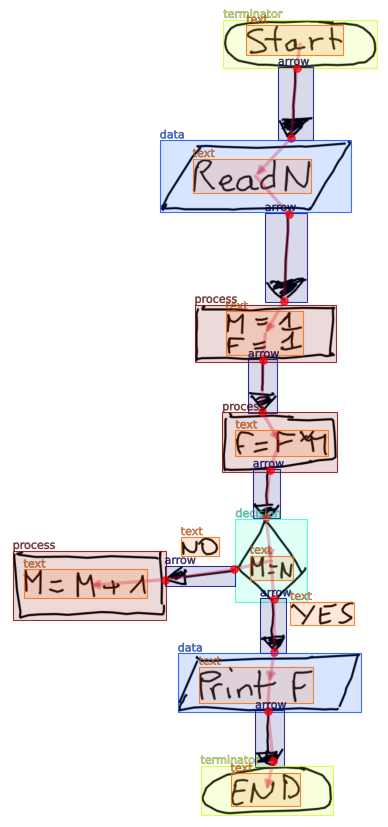

In [12]:
ai = random.choice(ann_imgs)
ai.plot(figsize=(8,8), font_size_scale=1., alpha_kp=0.7)

In [30]:
dir(ai.annotations[0])

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_fields',
 'bb',
 'category',
 'extra_fields',
 'get',
 'img_cropped',
 'plot',
 'set']

In [28]:
ai.annotations[0].bb.bb_coco, ai.annotations[0].bb.xy_w_h

((355, 4, 256, 81), ((355, 4), 256, 81))